# Part 2 

- Topic Modelling
- Information Extraction
- Job Similarity
- Overall Findings and recommendation

Import the necessasry libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
from tqdm import tqdm_notebook
from IPython.display import Markdown, display

import re
import nltk
import spacy
import gensim

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection  import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, silhouette_score

Import the corpus after data cleaning from the part 1.

In [2]:
data = pd.read_pickle("prepared_job_data.pkl")

In [3]:
data.drop(columns='Unnamed: 0',inplace=True)

In [4]:
data.head(2)

,jobpost,Title,JobRequirment,JobDescription,RequiredQual,AboutC,IT,Year
0,ameria investment consulting chief financial o...,chief financial officer,supervises financial management administrative...,ameria investment consulting seeking chief fin...,perform successfully individual must able perf...,mentor graphic development service cjsc subsid...,False,2004
1,international research exchange board irex ful...,full time community connection intern paid int...,participate design provide necessary technical...,incumbent work direct supervision president pr...,bachelor degree master preferred excellent ski...,international research exchange board irex u b...,False,2004


### --------------------------------------------------------------------------------------------------------------------------------

## Topic Modelling 

Determining the Nature of jobs over time

- LDA model

In [5]:
from gensim import corpora

In [6]:
job_post_token = data.jobpost.map(word_tokenize)

In [7]:
job_dict = corpora.Dictionary(job_post_token)
job_dict.filter_extremes(no_below=3, no_above=0.7)

In [8]:
dtm = [job_dict.doc2bow(d) for d in job_post_token]

Model implementation

In [9]:
pkl_filename = "lda.pkl"

In [10]:
# Load from file
with open(pkl_filename, 'rb') as file:
    lda = pickle.load(file)

In [11]:
topics  = lda.get_document_topics(dtm)

In [12]:
lda.show_topics()

[(0,
  '0.016*"november" + 0.015*"course" + 0.014*"online" + 0.014*"http" + 0.014*"medium" + 0.013*"training" + 0.012*"form" + 0.012*"learning" + 0.012*"october" + 0.010*"expert"'),
 (1,
  '0.018*"management" + 0.017*"ability" + 0.012*"manager" + 0.011*"business" + 0.011*"line" + 0.010*"ensure" + 0.010*"service" + 0.010*"marketing" + 0.008*"activity" + 0.008*"communication"'),
 (2,
  '0.025*"interested" + 0.023*"term" + 0.019*"russian" + 0.018*"excellent" + 0.017*"responsible" + 0.017*"subject" + 0.016*"field" + 0.016*"duration" + 0.015*"good" + 0.014*"send"'),
 (3,
  '0.050*"project" + 0.024*"development" + 0.017*"program" + 0.013*"support" + 0.013*"implementation" + 0.011*"activity" + 0.010*"community" + 0.009*"sector" + 0.009*"including" + 0.009*"international"'),
 (4,
  '0.022*"development" + 0.020*"software" + 0.017*"team" + 0.016*"design" + 0.014*"customer" + 0.012*"sale" + 0.012*"system" + 0.011*"ability" + 0.010*"developer" + 0.009*"technical"'),
 (5,
  '0.029*"financial" + 0.0

From the above the lda out the following topics are found for job posts, <br>
**Topic 0** : Education and Taining <br>
**Topic 1** : Business management and Marketting <br>
**Topic 2** : general <br>
**Topic 3** : Project Management <br>
**Topic 4** : Software development <br>
**Topic 5** : Accounting and Finance <br>
**Topic 6** : Event managing <br>

In [13]:
topic_dict = {0:'Education_and_Taining', 1:'Business_management_and_Marketting', 2:'general', 3:'Project_Management',
            4:'Software_development', 5:'Accounting_and_Finance', 6:'Event_managing'}

Topic Frequencies

In [14]:
from operator import itemgetter

In [15]:
top = [max(t, key=itemgetter(1))[0] for t in topics]

In [16]:
top = pd.Series(top)
data['topic'] = top

In [17]:
topic_name = pd.Series([topic_dict[i] for i in data.topic])

In [18]:
top_year_data = pd.concat([data.topic, topic_name, data.Year], axis=1)

In [19]:
top_year_data.columns = ['topic', 'topic_name', 'Year']

In [20]:
df = top_year_data.groupby(['topic_name'], sort = False).count()

<Figure size 360x72 with 0 Axes>

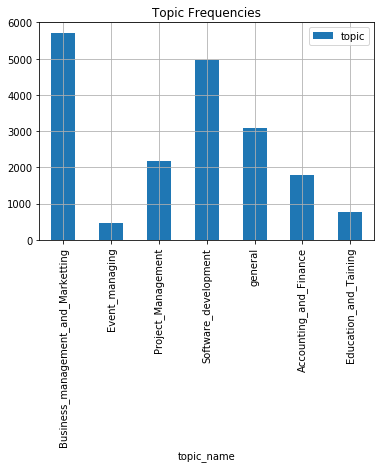

In [21]:
plt.figure(figsize=(5,1))
df[['topic']].plot(kind='bar')
plt.title('Topic Frequencies')
plt.xticks(rotation=90)
plt.show()

From the plot it is noted that, <br>
Topic 1 (**Business management and Marketting**) and Topic 4 (**Software development**)  maximum frequencies 

Visualization using the pyLDAvis

In [22]:
import pyLDAvis
import pyLDAvis.gensim

In [23]:
corpora.MmCorpus.serialize('corpus.mm', dtm)

In [24]:
corpus = gensim.corpora.MmCorpus('corpus.mm')

In [25]:
from IPython.core.display import display, HTML

In [26]:
display(HTML('topic_visualization.html'))
display(HTML("<style>.container { width:90% !important; }</style>"))

### ----------------------------------------------------------------------------------------------------------------------------

**Observing the changes in Topics over a period of time**

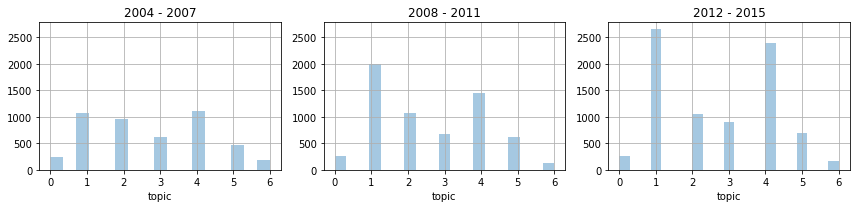

In [27]:
plt.figure(figsize=(12,3))

ax1 = plt.subplot(1, 3, 1)
sns.distplot(top_year_data.topic[top_year_data.Year.isin([2004,2005,2006,2007])], kde=False).set_title('2004 - 2007')

ax2 = plt.subplot(1, 3, 2, sharey = ax1)
sns.distplot(top_year_data.topic[top_year_data.Year.isin([2008, 2009, 2010, 2011])], kde=False).set_title('2008 - 2011')

ax3 = plt.subplot(1, 3, 3, sharey = ax1)
sns.distplot(top_year_data.topic[top_year_data.Year.isin([2012, 2013, 2014,2015])], kde=False).set_title('2012 - 2015')

plt.tight_layout()
plt.show()

In [28]:
topic_dict

{0: 'Education_and_Taining',
 1: 'Business_management_and_Marketting',
 2: 'general',
 3: 'Project_Management',
 4: 'Software_development',
 5: 'Accounting_and_Finance',
 6: 'Event_managing'}

From the above plots, <br>
There is a increasing number of job posts over the years. <br>
The pattern remain the same for the three sections. <br>
Business management and Marketting showing highest increase every year which was lower than Software development initially.<br>
Event management shows declining pattern

### ----------------------------------------------------------------------------------------------------------------------------

## Information Extraction

**Information extraction to extract Company profiles**

In [29]:
data['AboutC'].head() #AboutC gives the description of the company

0    mentor graphic development service cjsc subsid...
1    international research exchange board irex u b...
2    caucasus environmental ngo network non governm...
3    mentor graphic development service cjsc subsid...
4    mentor graphic development service cjsc subsid...
Name: AboutC, dtype: object

In [30]:
from spacy.matcher import Matcher

In [31]:
nlp = spacy.load('en_core_web_sm')
matcher = Matcher(nlp.vocab)

In [32]:
def collect_sents(matcher, doc, i, matches):
    match_id, start, end = matches[i]
    span = doc[start : end]  # matched span
    sent = span.sent  # sentence containing matched span
    match_ents = [{'start': span.start_char - sent.start_char,
                   'end': span.end_char - sent.start_char,
                   'label': 'MATCH'}]
    matched_sents.append({'text': sent.text, 'ents': match_ents })

In [33]:
pattern1 = [{'POS':'ADJ'},{'ORTH': '-'}, {'POS':'NOUN', 'OP':'+'}, {'LOWER': 'organization'}]
pattern2 = [{'POS':'NOUN', 'OP':'+'}, {'LOWER': 'organization'}]
pattern3 = [{'POS':'NOUN', 'OP':'+'}, {'LOWER': 'company'}]
pattern4 = [{'POS':'NOUN', 'OP':'+'}, {'LOWER': 'services'}]
pattern5 = [{'LOWER': 'company'}, {'POS':'VERB'}, {'POS':'NOUN', 'OP':'+'}]
pattern6 = [{'LOWER':'provider'}, {'POS':'ADP'}, {'POS':'NOUN',  'OP': '+'}  , {'POS':'CCONJ','OP':'+'}, {'POS':'NOUN','OP':'+'}]
pattern7 = [{'LOWER':'provider'}, {'POS':'ADP'}, {'POS':'NOUN',  'OP': '+'}]
pattern8 = [{'POS':'VERB'}, {'POS':'NOUN',  'OP': '+'} ]
pattern9 = [{'POS':'ADJ'}, {'POS':'NOUN',  'OP': '+'} ]
pattern10 = [{'POS':'NOUN'}, {'POS':'ADP'}, {'POS':'NOUN',  'OP': '+'} ]
pattern11 = [{'POS':'NOUN'}, {'POS':'NOUN','OP':'+'}]

In [34]:
pkl_filename = "company_fd.pkl"

In [35]:
# Load from file
with open(pkl_filename, 'rb') as file:
    fd = pickle.load(file)

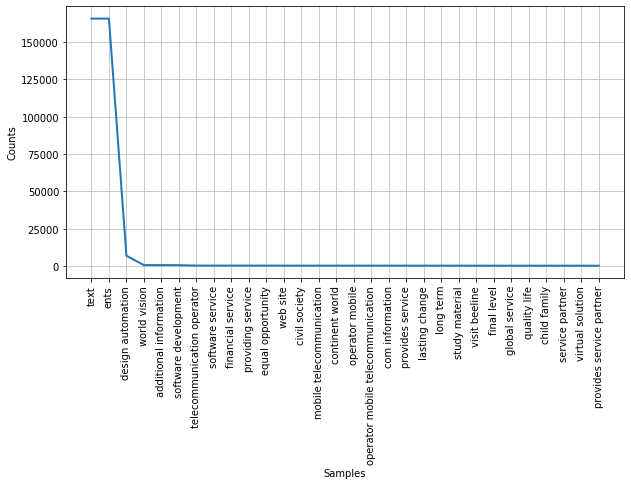

<Figure size 432x288 with 0 Axes>

In [36]:
plt.figure(figsize=(10, 5))
fd.most_common(50)
fd.plot(30)
plt.tight_layout()

In [37]:
fd.most_common(30)

[('text', 165698),
 ('ents', 165698),
 ('design automation', 6835),
 ('world vision', 564),
 ('additional information', 558),
 ('software development', 512),
 ('telecommunication operator', 257),
 ('software service', 245),
 ('financial service', 244),
 ('providing service', 240),
 ('equal opportunity', 236),
 ('web site', 221),
 ('civil society', 220),
 ('mobile telecommunication', 220),
 ('continent world', 217),
 ('operator mobile', 216),
 ('operator mobile telecommunication', 216),
 ('com information', 215),
 ('provides service', 206),
 ('lasting change', 204),
 ('long term', 199),
 ('study material', 197),
 ('visit beeline', 195),
 ('final level', 194),
 ('global service', 186),
 ('quality life', 185),
 ('child family', 178),
 ('service partner', 178),
 ('virtual solution', 177),
 ('provides service partner', 176)]

The above are the most common company profile.

### ----------------------------------------------------------------------------------------------------------------------------

### Job Similarity

To identify the job similarity between jobs, four columns were selected. Title, RequiredQual, JobDescription and JobRequiement

In [38]:
len(data.Title.unique())

8013

In [39]:
data['JobDescription_token'] = data['JobDescription'].map(word_tokenize)
data['RequiredQual_token'] = data['RequiredQual'].map(word_tokenize)
data['JobRequirment_token'] = data['JobRequirment'].map(word_tokenize)

**Using the TF-IDF vectorizer**

In [40]:
tv = TfidfVectorizer()
Title_tv = tv.fit_transform(data['Title'])
JobDescription_tv = tv.fit_transform(data['JobDescription'])
RequiredQual_tv = tv.fit_transform(data['RequiredQual'])
JobRequirment_tv = tv.fit_transform(data['JobRequirment'])

Function for finding the 5 most similar jobs for given job using cosine similarity metrics

In [41]:
def find_similar_jobs_tv(index, top_n = 5):
    Title_tv_cosine = cosine_similarity(Title_tv[index:index+1], Title_tv).flatten()
    JobDescription_tv_cosine = cosine_similarity(JobDescription_tv[index:index+1], JobDescription_tv).flatten()
    RequiredQual_tv_cosine = cosine_similarity(RequiredQual_tv[index:index+1], RequiredQual_tv).flatten()
    JobRequirment_tv_cosine = cosine_similarity(JobRequirment_tv[index:index+1], JobRequirment_tv).flatten()

    average_cosine = (Title_tv_cosine +JobDescription_tv_cosine+RequiredQual_tv_cosine+JobRequirment_tv_cosine)/4.0
    related_docs_indices = [i for i in average_cosine.argsort()[::-1] if i != index]
    return [(index, average_cosine[index]) for index in related_docs_indices][0:top_n]

In [42]:
def printmd(string):
    string = '_'+string+'_'
    display(Markdown(string))

Chief financial officer

In [43]:
data.iloc[0].Title

'chief financial officer'

In [44]:
for index, score in find_similar_jobs_tv(0,3):
    printmd(data.iloc[index].Title)
    print(data.iloc[index].jobpost[:70])
    print("SIMILARITY SCORE: ", score)
    print("----------------------------------------------------------------")

_chief financial officer_

organization implementation south road corridor investment program snc
SIMILARITY SCORE:  0.4477077954056993
----------------------------------------------------------------


_chief financial officer_

river island chief financial officer yerevan description river island 
SIMILARITY SCORE:  0.44268817852443193
----------------------------------------------------------------


_chief financial officer_

gritti chief financial officer term full time start time asap duration
SIMILARITY SCORE:  0.44216005761454513
----------------------------------------------------------------


Internship

In [45]:
data.iloc[1].Title

'full time community connection intern paid internship'

In [46]:
for index, score in find_similar_jobs_tv(1,3):
    printmd(data.iloc[index].Title)
    print(data.iloc[index].jobpost[:80])
    print("SIMILARITY SCORE: ", score)
    print("----------------------------------------------------------------")

_teacher full time_

military institute mod ra full time yerevan degree computer science information 
SIMILARITY SCORE:  0.6824664284763577
----------------------------------------------------------------


_non paid part full time administrative intern_

international research exchange board irex non paid part full time administrativ
SIMILARITY SCORE:  0.67663381892011
----------------------------------------------------------------


_non paid part full time programmatic intern_

international research exchange board irex non paid part full time programmatic 
SIMILARITY SCORE:  0.665398959778587
----------------------------------------------------------------


Software developer 

In [47]:
data.iloc[4].Title

'software developer'

In [48]:
for index, score in find_similar_jobs_tv(4,3):
    printmd(data.iloc[index].Title)
    print(data.iloc[index].jobpost[:80])
    print("SIMILARITY SCORE: ", score)
    print('''hello''')
    print("----------------------------------------------------------------")

_software developer_

converse bank cjsc software developer yerevan description design develop softwar
SIMILARITY SCORE:  0.5760695155473291
hello
----------------------------------------------------------------


_software developer_

converse bank cjsc software developer yerevan description develop implement new 
SIMILARITY SCORE:  0.5737643542416898
hello
----------------------------------------------------------------


_software developer_

cascade capital holding cjsc software developer yerevan description develop data
SIMILARITY SCORE:  0.5656704358968097
hello
----------------------------------------------------------------


Accountant

In [49]:
data.iloc[6].Title

'chief accountant finance assistant'

In [50]:
for index, score in find_similar_jobs_tv(6,3):
    printmd(data.iloc[index].Title)
    print(data.iloc[index].jobpost[:80])
    print("SIMILARITY SCORE: ", score)
    print("----------------------------------------------------------------")

_chief accountant_

moscow state university economics statistic information chief accountant term fu
SIMILARITY SCORE:  0.5551694415320927
----------------------------------------------------------------


_chief accountant_

doubletree hilton hotel yerevan chief accountant term full time duration long te
SIMILARITY SCORE:  0.5516590377191786
----------------------------------------------------------------


_chief accountant assistant_

caparol georgia ltd chief accountant assistant tbilisi georgia description board
SIMILARITY SCORE:  0.5457632645048219
----------------------------------------------------------------


### ----------------------------------------------------------------------------------------------------------------------------

### Findings & Recommendation<br>
This text mining project shows that by carefully pre-processing the various job ads posts and the
unstructured data, we can gain valuable insights about the Armenian labour market.<br>

By using **K-Means clustering**, we created an understanding of the required
qualifications and skillset in the Armenia labour market over the 10-year period from 2004 to 2015. We can clearly see that Management and communication skills are in constant high demand over the period and IT related skills have increased over the period.<br>

With the application of **LDA statistical model** on the full text of the job post with tuned parameters, we are able to show the main job "topics" of the online job ads. And by counting the
frequency of the job post topics, we revealed that the greatest number of job posting are related to
Sales and Marketing with Software development in second place. Plotting the results over the 10-year
period show clearly that software development jobs postings have the strongest growth.<br>

Using **pattern matching rules** on the company's description, we are able to get a feel of the type of companies that were posting on the job marketplace. This information can be used to supplement the
findings to get a better picture of the job market.<br>

In addition to understanding the dynamics of the Armenia labour market, we can perform advanced
text analytics to provide added value to the Armenian job portal. We have demonstrated that we are
also able to train good classification model to enhance the job portal, automatically classifying if the job posting is IT related. Also, by implementing **job similarity** search via cosine similarity between the text columns embeddings, we are able to create a useful feature that job seekers can use to find similar jobs in the job portal that he/she can apply to.<br>

### ======================================================================